In [170]:
import os
import sys
import random
import io
import requests
import pandas as pd
import numpy as np
import dicom
import matplotlib.pyplot as plt
sys.path.append('/home/mingot/lung_cancer_ds_bowl/src')
from utils import plotting, reading, preprocessing
from dl_model_patches import common

INPUT_FOLDER = '/home/shared/data/stage1'
NEW_SPACING = np.array([2, 0.7, 0.7])

# Get nodules df from annotation tool
url = "http://34.198.153.25:8009/patients/dsb_annotations.csv"
s = requests.get(url).content
annotations_df = pd.read_csv(io.StringIO(s.decode('utf-8')))
print 'Pacientes anotados con herramienta:', len(set(annotations_df['patientid']))

# Get patches
SCORE_TH = 0.7
preds_df = pd.read_csv('/home/shared/output/resnet/nodules_patches_dl1_v11.csv')
preds_df = preds_df[preds_df["score"] > SCORE_TH]
print 'patches df shape', preds_df.shape

# Get suggested annotations

# be: '33dd6666d9f0338929ecce58bb7c4cc3'
# reverse: '348a53f500ada390ddd00cc47d310b2c'
# reverse:

Pacientes anotados con herramienta: 164
patches df shape (147957, 7)


Patient ID: fc545aa2f58509dc6d81ef02130b6906
ORIENTATION: 8.070000
Patient original shape: (265, 512, 512)
Patient new shape: [ 166.  486.  486.]
Cropping adjustment: -13


                          patientid  has_cancer  nslice    x    y  height  \
1  fc545aa2f58509dc6d81ef02130b6906           1     176  133  224      21   

   width  
1     18  
                                        patientid  nslice    x    y  diameter  \
7746919  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      32  308  213     3.192   
7747053  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      38  355  188     4.652   
7747058  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      39  216  303     2.257   
7747252  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      46  201  206     5.171   
7747313  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      47  323  220     3.568   
7747344  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      48  319  213     2.764   
7747485  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      53  212  335    10.155   
77

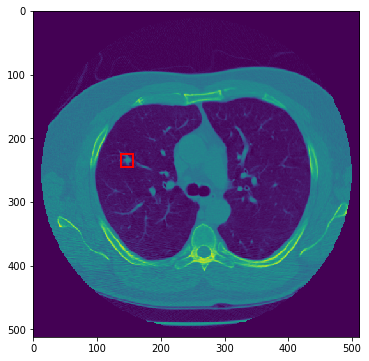

Predictions
                                        patientid  nslice    x    y  diameter  \
7747546  dsb_fc545aa2f58509dc6d81ef02130b6906.npz      55  233  147    12.153   

           score  label  
7747546  0.97421      0  


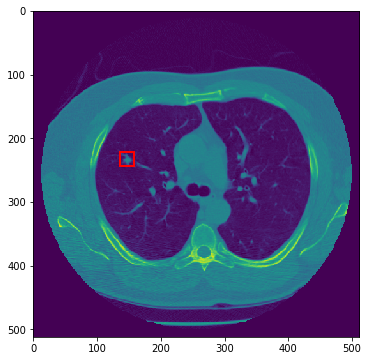

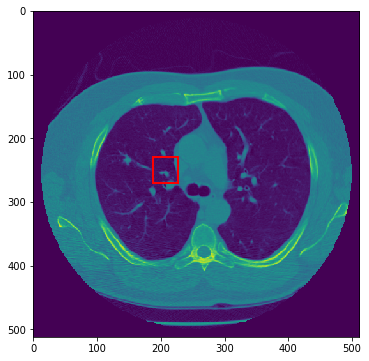

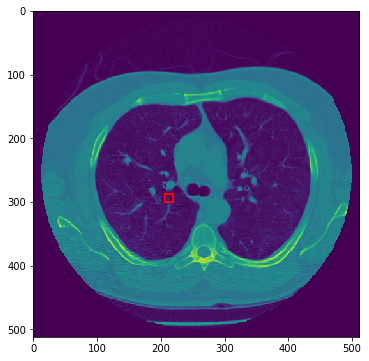

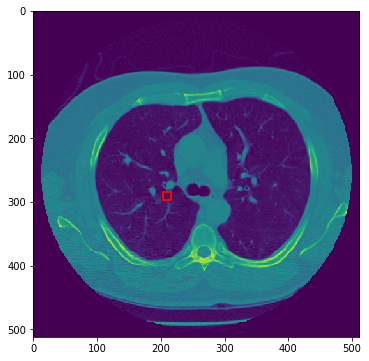

Rois


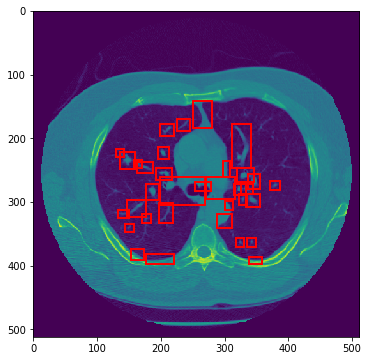

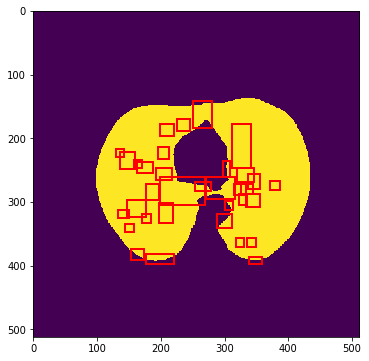

In [188]:
patid = 'fc545aa2f58509dc6d81ef02130b6906'
#patid = random.choice(list(set(annotations_df['patientid'])))
print 'Patient ID:', patid

# Get patient data
patidf = "/mnt/hd2/preprocessed5/dsb_%s.npz" % patid
pdata = np.load(patidf)['arr_0']
# plt.imshow(pdata[0,80])
# plt.show()

#plotting.multiplot(pdata[1])

# Filter annotations and patches
preds_df_sel = preds_df[preds_df['patientid']=="dsb_%s.npz" % patid]
df = annotations_df[annotations_df['patientid']==patid]

# Get spacing factor
patient = reading.load_scan(os.path.join(INPUT_FOLDER, patid))
print 'ORIENTATION:', patient[0].SliceLocation
patient_pixels = preprocessing.get_pixels_hu(patient)
original_spacing = reading.dicom_get_spacing(patient)
sf = original_spacing/NEW_SPACING #scale_factor
print "Patient original shape:", patient_pixels.shape
new_shape = np.round(patient_pixels.shape*sf)
print "Patient new shape:", new_shape
crop_adj = int(new_shape[1] - 512)/2
print "Cropping adjustment:", crop_adj
print "\n"

print df
print preds_df_sel

for idx, row in df.iterrows():
    nslice,x,y,w,h = row['nslice'],row['x'],row['y'],row['height'],row['width']
    nslice = patient_pixels.shape[0] - nslice  # OJO: sometimes the z is inverted
    x -= crop_adj
    y -= crop_adj
    nslice,x,y,width,height = int(nslice*sf[0]),int(x*sf[1]),int(y*sf[1]),int(h*sf[1]),int(w*sf[1])

    a = common.AuxRegion(bbox=[y,x,y+w,x+h])
    print "Real nodules (slice: %d)" % nslice
    plotting.plot_bb(pdata[0,nslice], [a])

    print "Predictions"
    print preds_df_sel[preds_df_sel['nslice']==nslice]
    pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==nslice]) 
    plotting.plot_bb(pdata[0,nslice], pred_regions)
    
    pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==61]) 
    plotting.plot_bb(pdata[0,nslice], pred_regions)
    pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==62]) 
    plotting.plot_bb(pdata[0,nslice], pred_regions)
    pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==63]) 
    plotting.plot_bb(pdata[0,nslice], pred_regions)
    
    print "Rois"
    rois = extract_rois_from_lung_mask(pdata[0,nslice], pdata[1,nslice])
    plotting.plot_bb(pdata[0,nslice], rois)
    plotting.plot_bb(pdata[1,nslice], rois)

    
# #     pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==nslice+1]) 
# #     plotting.plot_bb(pdata[0,nslice+1], pred_regions)
# #     pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==nslice-1]) 
# #     plotting.plot_bb(pdata[0,nslice-1], pred_regions)
    


In [183]:
from skimage import measure, transform, morphology

def calc_area(r):
    return (r.bbox[2]-r.bbox[0])*(r.bbox[3]-r.bbox[1])


def calc_ratio(r):
    return (r.bbox[2]-r.bbox[0])*1.0/(r.bbox[3]-r.bbox[1])



class AuxRegion():
    """Auxiliar class to change the bbox of regions props."""
    def __init__(self, region=None, bbox=None):
        if region is not None:
            self.bbox = region.bbox
            self.centroid = region.centroid
            self.equivalent_diameter = region.equivalent_diameter
        elif bbox is not None:
            self.bbox = bbox

    def augment_region(self, margin=5):
        self.bbox = [max(self.bbox[0]-margin,0), max(self.bbox[1]-margin,0), self.bbox[2]+margin, self.bbox[3]+margin]

    def cropped_image(self, img, output_size=(40,40)):
        x1,y1,x2,y2 = self.bbox
        if len(img.shape)==2:  # a single image to be cropped
            cropped = img[x1:x2,y1:y2]
            return transform.resize(cropped, output_size)

        elif len(img.shape)==3:  #
            stack_crops = []
            cropped = img[:,x1:x2,y1:y2]
            for nslice in range(img.shape[0]):
                stack_crops.append(transform.resize(cropped[nslice], output_size))
            return np.stack(stack_crops)

def augment_bbox(r, margin=5):
    """Increase pixels by margin."""
    r.bbox = (max(r.bbox[0]-margin,0), max(r.bbox[1]-margin,0), r.bbox[2]+margin, r.bbox[3]+margin)
    return r


def get_regions(mask, threshold=None):
    if threshold is None:
        threshold = np.mean(mask)

    thr = np.where(mask < threshold, 0., 1.0)
    label_image = measure.label(thr)  # label them
    labels = label_image.astype(int)
    regions = measure.regionprops(labels)
    return regions



def extract_rois_from_lung_mask(lung_image, lung_mask, margin=5):
    """
        Given a lung image,  generate ROIs based on HU filtering.
        Reduce the candidates by discarding smalls and very rectangular regions.
    """
    mask = lung_image.copy()
    mask[lung_mask!=1] = -2000
    mask[mask<-500] = -2000  # based on LUNA examination ()

    # generate regions
    #mask = morphology.opening(mask)
    regions_pred = get_regions(mask, threshold=np.mean(mask))

    # discard small regions or long connected regions
    sel_regions = []
    for region in regions_pred:
        area, ratio = calc_area(region), calc_ratio(region)
        if 3*3<=area:# and area<=900*900 and 1.0/3<=ratio and ratio<=3:  # regions in [2.1mm, 40mm]
            sel_regions.append(region)
    regions_pred = sel_regions


    # increase the padding of the regions by 5px
    regions_pred_augmented = []
    for region in regions_pred:
        region = AuxRegion(region)
        region = augment_bbox(region, margin=margin)
        regions_pred_augmented.append(region)

    return regions_pred_augmented